In [24]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib
import time
import pickle
import scipy
from scipy.stats import norm
from scipy.stats import multivariate_normal as mltnorm
from scipy.sparse import csr_matrix
from scipy.stats import randint
from scipy.stats import uniform
from scipy.optimize import minimize
import copy
import math
import time
from scipy.optimize import minimize
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals
import scipy
from sklearn.datasets import load_svmlight_file
import pickle
from pathlib import Path
%matplotlib inline

In [25]:
from functions import *

In [26]:
from algorithms_comp import *

In [27]:
from utils import *

# Negative log-likelihood

## a9a

In [28]:
%%time
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Number of functions in the sum: ", m, ", dimension of the problem: ", n)
L, average_L, worst_L = compute_L(dataset, A)
denseA = A.toarray()
print("Smoothness constant of the sum: ", L)
print("Average smoothness constant   : ", average_L)
print("Worst smoothness constant     : ", worst_L)
print("Fraction of non-zero elemenst : ", sparsity_A)

Number of functions in the sum:  32561 , dimension of the problem:  123
Smoothness constant of the sum:  1.5719196992226567
Average smoothness constant   :  3.467276803535652
Worst smoothness constant     :  3.5
Fraction of non-zero elemenst :  0.11275696922074716
CPU times: total: 422 ms
Wall time: 477 ms


### Find the solution

In [29]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = 0
l1 = 0

In [30]:
%%time
param = [A, y, l2, False]
res_solver = minimize(negative_loglikelihood_loss, x_init, args = param, jac=negative_loglikelihood_loss_grad, 
                      method='L-BFGS-B',
                      options={'maxiter':10000, 'disp':True}, tol=1e-10)

print(res_solver.success)
print(res_solver.fun)
print(res_solver)

True
0.32262113028924144
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.32262113028924144
        x: [-1.208e+00 -2.241e-01 ...  1.175e-01 -1.169e+00]
      nit: 1169
      jac: [-4.360e-08  1.559e-07 ...  7.680e-08  8.675e-08]
     nfev: 1325
     njev: 1325
 hess_inv: <123x123 LbfgsInvHessProduct with dtype=float64>
CPU times: total: 10.8 s
Wall time: 10.8 s


In [32]:
l2 = 0
l1 = 0
sparse = False
sparse_full = True


bs = 100

x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]

num_of_non_zeros = 1
x_init = deepcopy(x_star)
shift_param = 10
x_init[0:num_of_non_zeros] += shift_param
N = 20000

filename = dataset+"_init_first_"+str(num_of_non_zeros)+"_shift_"+str(shift_param)
delta = 0
t = 1e-1
param = [negative_loglikelihood_loss, A, y, l2, sparse, sparse_full, L, delta, 1, t]


print("f(x_0)-f(x^*) = ", negative_loglikelihood_loss(x_init, [A, y, l2, False, t]) - f_star)
epsilon = 1e-3

f(x_0)-f(x^*) =  0.8268586255819828


In [33]:
%%time
# tuning_stepsize_param_options_ardfds_e = [1e-1, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2]
stepsizes = [1, 1e-1, 1e-2]
batchsizes = [300]
for step_param in stepsizes:
    for bs in batchsizes: 
        Our_method = ZO_AccSGD(filename, x_init, args=param, bs=bs, N=N,
                            f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
        print('Finished with lr = {} and bs = {}'.format(step_param, bs))

  0%|          | 0/2170733 [00:00<?, ?it/s]

  0%|          | 564/2170733 [00:14<15:04:38, 39.98it/s]


KeyboardInterrupt: 

In [19]:
batchsizes = [1000, 5000]
for bs in batchsizes: 
        Our_method = ZO_AccSGD(filename, x_init, args=param, bs=bs, N=N,
                            f_star=f_star, x_star=x_star, tuning_stepsize_param=1)
        print('Finished with lr = {} and bs = {}'.format(1 /(L * bs), bs))

  0%|          | 0/651220 [00:00<?, ?it/s]

100%|██████████| 651220/651220 [2:54:08<00:00, 62.33it/s]  


Finished with lr = 0.0006361648120413011 and bs = 1000


100%|██████████| 130244/130244 [2:15:44<00:00, 15.99it/s] 

Finished with lr = 0.00012723296240826023 and bs = 5000


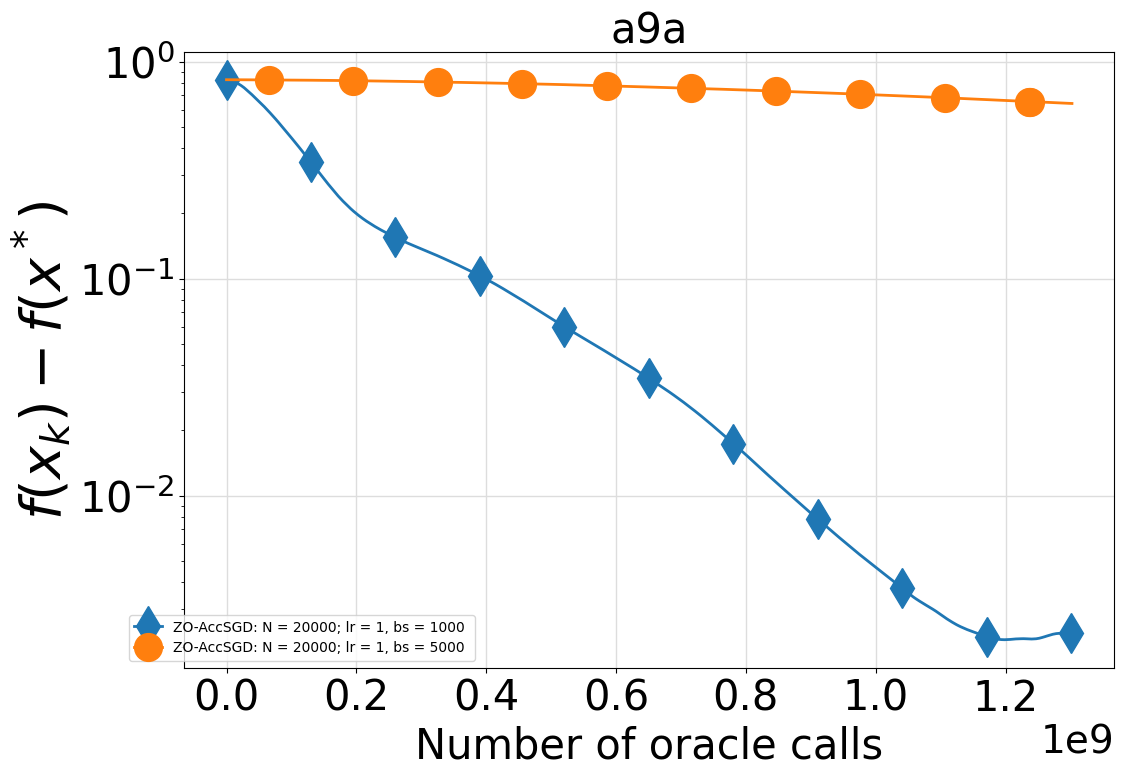

In [21]:
methods = []
# rho_list = [1e-1, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2]
# stepsizes = [1, 1e-1, 1e-2]
batchsizes = [1000, 5000]
for bs in batchsizes: 
    methods.append(['Our_algorithm logreg', [1, N, delta, bs],
                        f"ZO-AccSGD: N = {N}; lr = {1}, bs = {bs} ", None])


mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"Our_algorithm"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [22]:
l2 = 0
l1 = 0
sparse = False
sparse_full = True


bs = 100

x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]

num_of_non_zeros = 1
x_init = deepcopy(x_star)
shift_param = 11
x_init[0:num_of_non_zeros] += shift_param
N = 20000

filename = dataset+"_init_first_"+str(num_of_non_zeros)+"_shift_"+str(shift_param)
delta = 0
t = 1e-8
param = [negative_loglikelihood_loss, A, y, l2, sparse, sparse_full, L, delta, t]


print("f(x_0)-f(x^*) = ", negative_loglikelihood_loss(x_init, [A, y, l2, False, t]) - f_star)
epsilon = 1e-3

f(x_0)-f(x^*) =  1.0153286848598824


In [23]:
%%time
# tuning_stepsize_param_options_ardfds_e = [1e-1, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2]
stepsizes = [1e-1]
batchsizes = [1000]
for step_param in stepsizes:
    for bs in batchsizes: 
        ARDFDS = ardfds_e_noise_logreg(filename, x_init, args=param, bs=bs, N=N,
                            f_star=f_star, x_star=x_star, tuning_stepsize_param=step_param)
        print('Finished with lr = {} and bs = {}'.format(step_param, bs))

  0%|          | 0/651220 [00:00<?, ?it/s]

100%|██████████| 651220/651220 [07:58<00:00, 1359.62it/s]

Finished with lr = 0.1 and bs = 1000
CPU times: total: 8min 28s
Wall time: 7min 58s


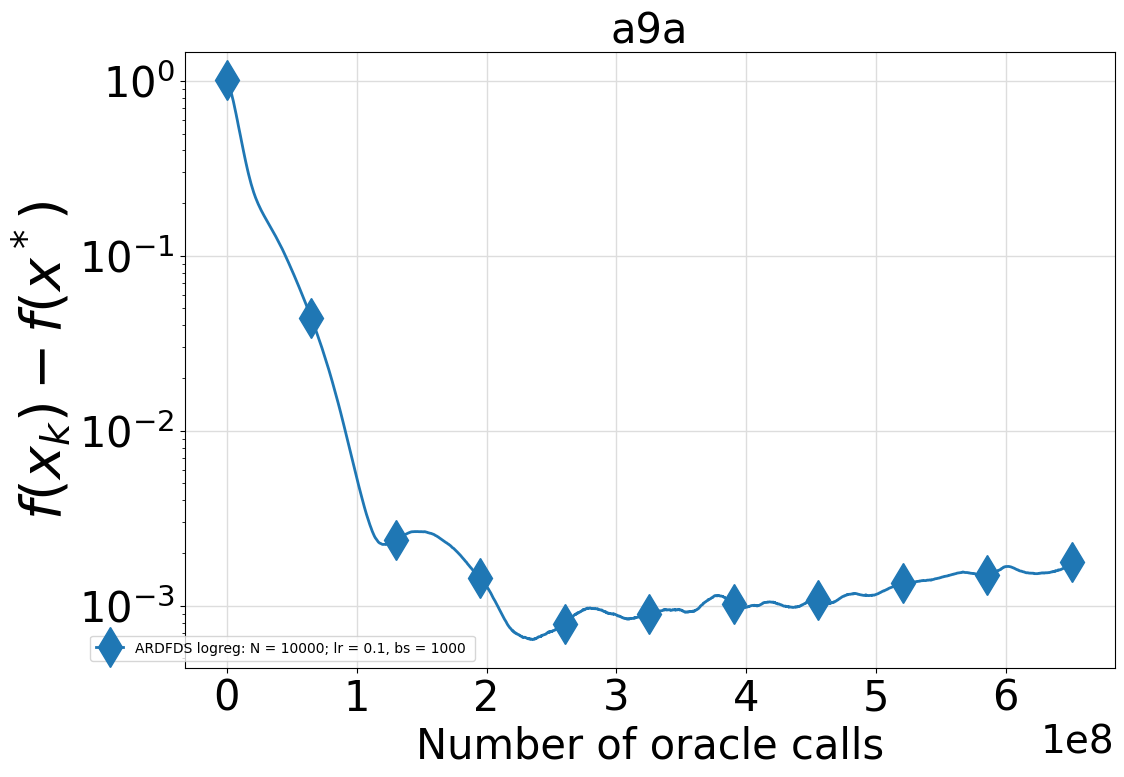

In [16]:
methods = []
# rho_list = [1e-1, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2]
stepsizes = [1e-1]
batchsizes = [1000]
for step_param, bs in zip(stepsizes, batchsizes):
    methods.append(['ARDFDS_E logreg', [step_param, N, delta, bs],
                        f"ARDFDS logreg: N = {N}; lr = {step_param}, bs = {bs} ", None])


mode_y = 'func_vals'
mode_x = 'oracle_calls'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 20
legend_size = 10
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset
bbox_to_anchor = (0.32,0)
legend_loc=4

save_fig = [True, filename+"ARDFDS_E_logreg"+"_delta_"+str(delta)
            +"_batch_"+str(m)+".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)